In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from hyperopt import hp
from hyperopt.pyll import scope
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

ModuleNotFoundError: No module named 'hyperopt'

In [3]:
df.set_index("date", inplace=True)

In [4]:
len(df["electricity"])

2403

In [24]:
np.arange(time+1)[-1]

np.int64(2403)

In [25]:
time+1

2404

In [22]:
y = np.array(df["electricity"])
time = len(y)
lnr_fit2 = LinearRegression().fit(np.arange(time+0).reshape(-1, 1), y=y)
ses_forecast2 = lnr_fit2.predict(np.array([[time + 0]]))[0]
ses_forecast2


np.float64(894415.2254397587)

In [5]:
from arml import unit_root_test, plot_PACF_ACF, cat_forecaster, lightGBM_forecaster, xgboost_forecaster

In [6]:
unit_root_test(df["electricity"], method="ADF")

ADF p-value: 0.009384 and data is stationary at 5% significance level


(0.009383682866887066, None)

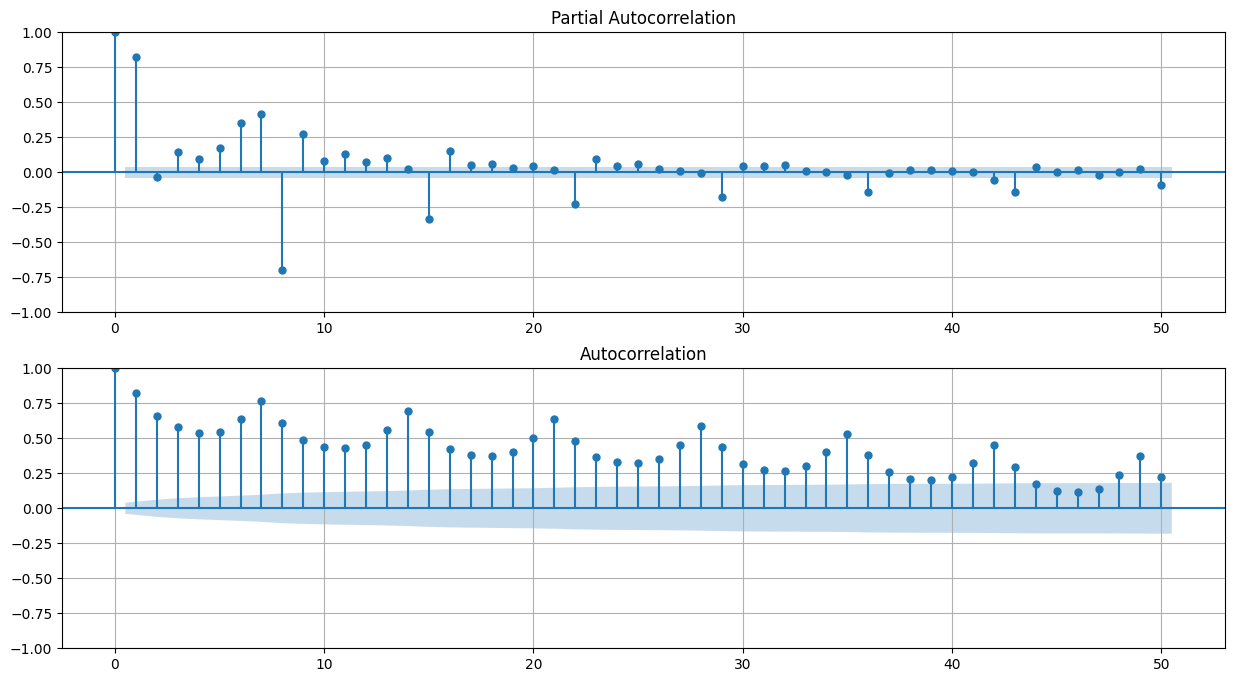

In [6]:
plot_PACF_ACF(df["electricity"], lag_num=50)

In [7]:
train_d, test_x, test_y = df[:-60], df[-60:].iloc[:,1:], df[-60:]["electricity"]

In [8]:
cat_dict = {"month": ['January','February', 'March','April','May','June', 'July', 'August', 'September', 'October', 'November', 'December'],
 "week_day": ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']}

In [12]:
params={'max_depth': scope.int(hp.quniform("max_depth", 3, 15, 1)), 
               'learning_rate': hp.quniform('learning_rate', 0.001, 0.4, 0.0001),
               'gamma': hp.quniform ('gamma', 0, 10, 0.0001), 'reg_alpha' : hp.quniform('reg_alpha', 0, 10, 0.0001),
               'reg_lambda' : hp.quniform('reg_lambda', 0, 10, 0.0001),
               'min_child_weight' : hp.quniform('min_child_weight', 0, 9, 0.001),
               'n_estimators': scope.int(hp.quniform("n_estimators", 50, 2500, 10)),
               'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.001),
               'colsample_bynode': hp.quniform('colsample_bynode', 0.5, 1, 0.0001),
               'seed': 0}

In [13]:
my_xgb = xgboost_forecaster(n_lag=21, target_col="electricity", cat_dict=cat_dict)

In [14]:
model = my_xgb.fit(train_d)

In [15]:
my_preds = my_xgb.forecast(model, n_ahead=len(test_x), x_test=test_x)

In [16]:
((np.array(test_y)-my_preds)/test_y).mean()*100

7.036911875440264

In [17]:
my_xgb = xgboost_forecaster(n_lag=21, target_col="electricity", cat_dict=cat_dict)

In [18]:
my_xgb.tune_model(train_d, 5, 60, param_space=params, eval_num=10)

SCORE:                                                
5.255330935986209                                     
SCORE:                                                                         
5.490262940484643                                                              
SCORE:                                                                         
5.445835665707722                                                              
SCORE:                                                                         
5.346472540541091                                                              
SCORE:                                                                         
4.2925392453326126                                                             
SCORE:                                                                          
6.13133805524027                                                                
SCORE:                                                                          
6.43521

{'colsample_bynode': 0.9257000000000001,
 'colsample_bytree': 0.673,
 'gamma': 6.3621,
 'learning_rate': 0.02,
 'max_depth': 14,
 'min_child_weight': 7.97,
 'n_estimators': 1320,
 'reg_alpha': 2.9057,
 'reg_lambda': 3.2157}

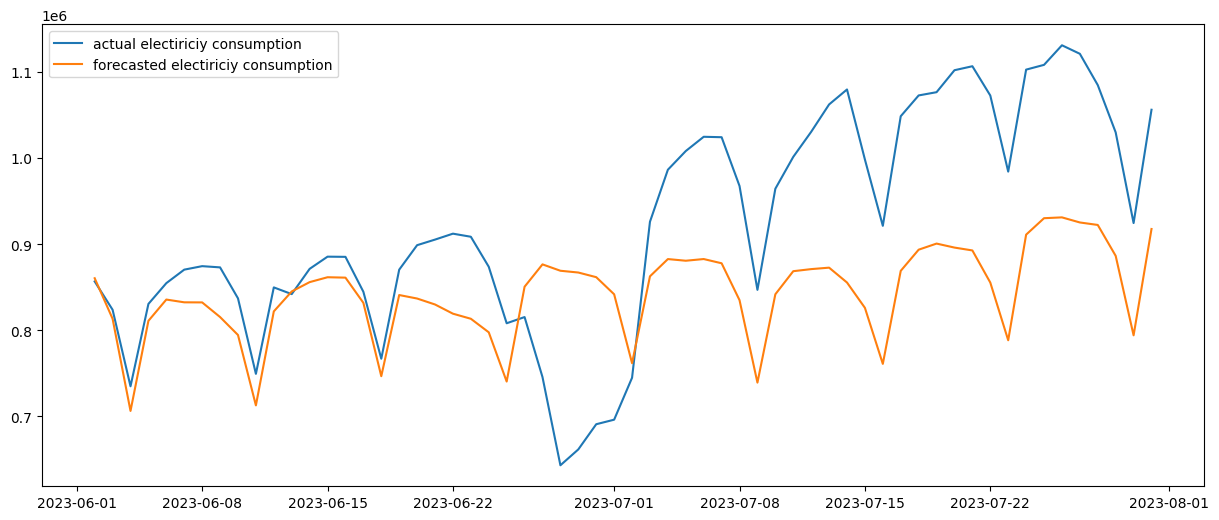

In [14]:
fig, ax = plt.subplots(figsize = (15,6))
ax.plot(test_y.index,test_y, label = "actual electiriciy consumption", color = "C0")
ax.plot(test_y.index, my_preds, label = "forecasted electiriciy consumption", color = "C1")
plt.legend(loc="upper left")
plt.show()